# This notebook is for course four : Classification Analysis (Supervised Learning)

In [52]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold

### Importing Data Files

In [5]:
#Import Product DataSet here
product_data = pd.read_csv('Product Data Set - Student 2 of 3.csv',sep='|')
product_data.head()

,PRODUCT CODE,PRODUCT CATEGORY,UNIT LIST PRICE
0,30001,HEALTH & BEAUTY,$7.45
1,30002,HEALTH & BEAUTY,$5.35
2,30003,HEALTH & BEAUTY,$5.49
3,30004,HEALTH & BEAUTY,$6.46
4,30005,HEALTH & BEAUTY,$7.33


In [6]:
#Import Transaction DataSet Here
transactions_data = pd.read_csv('Transaction Data Set - Student 3 of 3.csv',sep='|')
transactions_data.head()

,CUSTOMER NUM,PRODUCT NUM,QUANTITY PURCHASED,DISCOUNT TAKEN,TRANSACTION DATE,STOCKOUT
0,10114,30011,4,0.0,1/2/2015,0
1,10217,30016,3,0.0,1/2/2015,0
2,10224,30013,4,0.0,1/2/2015,0
3,10103,30012,3,0.2,1/2/2015,0
4,10037,30010,8,0.0,1/2/2015,0


In [7]:
#Import Customer Dataset Here
customer_data=pd.read_csv('Customer Data Set - Student 1 of 3.csv')
customer_data.head()

,CUSTOMERID,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,ENROLLMENT DATE,HOUSEHOLD SIZE,MARITAL STATUS
0,10001,0,64,"$133,498",5,enrolled,06-03-2013,4,Single
1,10002,0,42,"$94,475",9,notenrolled,NaN,6,Married
2,10003,0,40,"$88,610",9,enrolled,02-09-2010,5,Married
3,10004,0,38,"$84,313",8,enrolled,06-04-2015,1,Single
4,10005,0,30,"$51,498",3,notenrolled,NaN,1,Single


### Changing Data Types

In [8]:
customer_data['INCOME']=customer_data['INCOME'].map(lambda x : x.replace('$',''))

In [9]:
customer_data['INCOME']=customer_data['INCOME'].map(lambda x : int(x.replace(',','')))

### Creating Customer View

In [10]:
trans_products=transactions_data.merge(product_data,how='inner', left_on='PRODUCT NUM', right_on='PRODUCT CODE')

In [11]:
trans_products['UNIT LIST PRICE']=trans_products['UNIT LIST PRICE'].map(lambda x : float(x.replace('$','')))

In [12]:
trans_products['Total_Price']=trans_products['QUANTITY PURCHASED'] * trans_products['UNIT LIST PRICE'] * (1- trans_products['DISCOUNT TAKEN'])

In [13]:
customer_prod_categ=trans_products.groupby(['CUSTOMER NUM','PRODUCT CATEGORY']).agg({'Total_Price':'sum'})

In [14]:
customer_prod_categ=customer_prod_categ.reset_index()

In [15]:
customer_pivot=customer_prod_categ.pivot(index='CUSTOMER NUM',columns='PRODUCT CATEGORY',values='Total_Price')

In [16]:
trans_total_spend=trans_products.groupby('CUSTOMER NUM').agg({'Total_Price':'sum'}).\
rename(columns={'Total_Price':'TOTAL SPENT'})

In [17]:
customer_KPIs=customer_pivot.merge(trans_total_spend,how='inner',left_index=True, right_index=True )

In [18]:
customer_KPIs=customer_KPIs.fillna(0)


In [19]:
customer_all_view=customer_data.merge(customer_KPIs,how='inner', left_on='CUSTOMERID', right_index=True)

In [20]:
customer_all_view.head()

,CUSTOMERID,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,ENROLLMENT DATE,HOUSEHOLD SIZE,MARITAL STATUS,APPAREL,ELECTRONICS,FOOD,HEALTH & BEAUTY,TOTAL SPENT
0,10001,0,64,133498,5,enrolled,06-03-2013,4,Single,4022.430,1601.315,68.688,1134.337,6826.770
1,10002,0,42,94475,9,notenrolled,NaN,6,Married,2312.509,2473.163,276.779,0.000,5062.451
2,10003,0,40,88610,9,enrolled,02-09-2010,5,Married,2887.382,5414.418,260.640,0.000,8562.440
3,10004,0,38,84313,8,enrolled,06-04-2015,1,Single,3637.213,1840.211,45.270,0.000,5522.694
4,10005,0,30,51498,3,notenrolled,NaN,1,Single,213.512,0.000,0.000,0.000,213.512


# Classification 

In [21]:
#Create a Pandas data frame containing the most relevant features and the target variable
DF_classification=customer_all_view[['INCOME','AGE','EXPERIENCE SCORE','TOTAL SPENT','LOYALTY GROUP']]
DF_classification.head(5)

,INCOME,AGE,EXPERIENCE SCORE,TOTAL SPENT,LOYALTY GROUP
0,133498,64,5,6826.770,enrolled
1,94475,42,9,5062.451,notenrolled
2,88610,40,9,8562.440,enrolled
3,84313,38,8,5522.694,enrolled
4,51498,30,3,213.512,notenrolled


In [22]:
#Separate the target from the numerical input features (predictors) and create a Pandas data frame to hold only the target labels 
target_feature = pd.DataFrame(DF_classification['LOYALTY GROUP'])
print(type(target_feature))
target_feature.head(5)

<class 'pandas.core.frame.DataFrame'>


,LOYALTY GROUP
0,enrolled
1,notenrolled
2,enrolled
3,enrolled
4,notenrolled


In [23]:
DF_classification = DF_classification.drop(['LOYALTY GROUP'],axis=1)
DF_classification.head(5)

,INCOME,AGE,EXPERIENCE SCORE,TOTAL SPENT
0,133498,64,5,6826.770
1,94475,42,9,5062.451
2,88610,40,9,8562.440
3,84313,38,8,5522.694
4,51498,30,3,213.512


In [26]:
#Save the column names of the input Pandas data frame in a list before scaling
DF_classification_column_names = DF_classification.columns.values

In [27]:
#adjust the scales of the input features
DF_classification=preprocessing.minmax_scale(DF_classification)

In [28]:
#Reconstruct the input Pandas data frame from the NumPy array
DF_classification=pd.DataFrame(DF_classification, columns=DF_classification_column_names)
DF_classification.head(5)

,INCOME,AGE,EXPERIENCE SCORE,TOTAL SPENT
0,0.872818,0.638889,0.444444,0.446532
1,0.572046,0.333333,0.888889,0.330790
2,0.526842,0.305556,0.888889,0.560394
3,0.493722,0.277778,0.777778,0.360983
4,0.240799,0.166667,0.222222,0.012694


In [29]:
#concatenate the DF_classification with the target_feature data frame
DF_classification = pd.concat([DF_classification,target_feature], axis=1)
DF_classification.head(5)

,INCOME,AGE,EXPERIENCE SCORE,TOTAL SPENT,LOYALTY GROUP
0,0.872818,0.638889,0.444444,0.446532,enrolled
1,0.572046,0.333333,0.888889,0.330790,notenrolled
2,0.526842,0.305556,0.888889,0.560394,enrolled
3,0.493722,0.277778,0.777778,0.360983,enrolled
4,0.240799,0.166667,0.222222,0.012694,notenrolled


In [35]:
#generate the training and testing data sets
X_train,X_test,Y_train,Y_test = \
train_test_split(DF_classification[['EXPERIENCE SCORE','TOTAL SPENT','INCOME']],DF_classification['LOYALTY GROUP'], test_size=0.2,random_state=42)

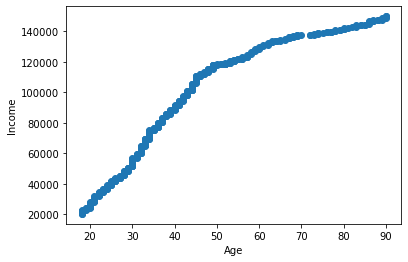

In [37]:
#Age and Income are highly correlated, so we do not care for this data as depicted below
plt.scatter(customer_all_view['AGE'],customer_all_view['INCOME'])
plt.xlabel("Age")
plt.ylabel("Income")
plt.show()

In [41]:
#Create an instance of the KNN classifier
clf_kNN = KNeighborsClassifier(n_neighbors=8)
clf_kNN

KNeighborsClassifier(n_neighbors=8)

In [43]:
#train the KNN classifier
clf_kNN.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=8)

In [45]:
#use the model to predict the labels of the testing feature
predicted = clf_kNN.predict(X_test)

In [47]:
#Compare the predicted values to the actual values of the testing target labels (Y_test)
acc = metrics.accuracy_score(Y_test,predicted)
print ('accuracy = '+str(acc*100)+'%')
print (metrics.classification_report(Y_test,predicted))

accuracy = 79.0%
              precision    recall  f1-score   support

    enrolled       0.73      0.92      0.82        51
 notenrolled       0.89      0.65      0.75        49

    accuracy                           0.79       100
   macro avg       0.81      0.79      0.79       100
weighted avg       0.81      0.79      0.79       100



In [50]:
#Create an instance of the algorithm with criterion = entropy
clf_Tree=DecisionTreeClassifier(criterion='entropy', random_state=0)
clf_Tree

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [51]:
#train and test the tree model
clf_Tree.fit(X_train, Y_train)
predicted = clf_Tree .predict(X_test)
acc = metrics.accuracy_score(Y_test,predicted)
print ('accuracy = '+str(acc*100)+'%')
print (metrics.classification_report(Y_test,predicted))

accuracy = 75.0%
              precision    recall  f1-score   support

    enrolled       0.74      0.78      0.76        51
 notenrolled       0.76      0.71      0.74        49

    accuracy                           0.75       100
   macro avg       0.75      0.75      0.75       100
weighted avg       0.75      0.75      0.75       100



In [53]:
#Define a new generic training and testing function with accuracy as the performance metric
def Training_Testing_Accuracy_Only(model,train_data,train_labels,test_data,test_labels):
    model.fit(train_data,train_labels)
    predicted = model.predict(test_data)
    acc = metrics.accuracy_score(test_labels,predicted)
    print ('accuracy = '+str(acc*100)+'%')
    return(acc)

In [54]:
#Set the number of folds
kf = KFold(n_splits=10)

In [55]:
#declare an empty list to store the accuracy in each iteration
clf_Tree=DecisionTreeClassifier(criterion='entropy')
accuracy_list=[]

In [56]:
#Train and test the decision tree model for each fold and get the overall accuracy
for train_index, test_index in kf.split(DF_classification[['EXPERIENCE SCORE','TOTAL SPENT','INCOME']]):
    X=DF_classification[['EXPERIENCE SCORE','TOTAL SPENT','INCOME']]
    Y=DF_classification['LOYALTY GROUP']
    X_train,X_test=X.iloc[train_index], X.iloc[test_index]
    Y_train,Y_test=Y.iloc[train_index], Y.iloc[test_index]   
    accuracy=Training_Testing_Accuracy_Only(clf_Tree,X_train,Y_train,X_test,Y_test)
    accuracy_list.append(accuracy) 
print("overall_accuracy is %",100 * sum(accuracy_list)/len(accuracy_list))

accuracy = 78.0%
accuracy = 74.0%
accuracy = 74.0%
accuracy = 72.0%
accuracy = 70.0%
accuracy = 84.0%
accuracy = 68.0%
accuracy = 74.0%
accuracy = 70.0%
accuracy = 82.0%
overall_accuracy is % 74.6


In [57]:
#declare an empty list to store the accuracy for each iteration of K_neighbors 
accuracy_list_for_each_K_neighbours=[]

In [58]:
#Train and test the KNN classifier by using two loops: An outer loop to iterate over the values of K neighbors 1 - 10 and an inner loop for training and testing the model by using cross-validation
for k_neighbours in range(1,15):
    clf_NN = KNeighborsClassifier(n_neighbors=k_neighbours)
    accuracy_list_k_fold = []
    for train_index, test_index in kf.split(DF_classification[['EXPERIENCE SCORE','TOTAL SPENT','INCOME']]):
        X=DF_classification[['EXPERIENCE SCORE','TOTAL SPENT','INCOME']]
        Y=DF_classification['LOYALTY GROUP']
        X_train,X_test=X.iloc[train_index], X.iloc[test_index]
        Y_train,Y_test=Y.iloc[train_index], Y.iloc[test_index]    
        accuracy=Training_Testing_Accuracy_Only(clf_NN,X_train,Y_train,X_test,Y_test)
        accuracy_list_k_fold.append(accuracy)
    accuracy_list_for_each_K_neighbours.append(100 * sum(accuracy_list_k_fold)/len(accuracy_list_k_fold))
    print("Overall Accuracy for K_neighbours=",k_neighbours,"is",accuracy_list_for_each_K_neighbours[k_neighbours-1])

accuracy = 64.0%
accuracy = 64.0%
accuracy = 66.0%
accuracy = 64.0%
accuracy = 82.0%
accuracy = 68.0%
accuracy = 70.0%
accuracy = 64.0%
accuracy = 76.0%
accuracy = 68.0%
Overall Accuracy for K_neighbours= 1 is 68.6
accuracy = 74.0%
accuracy = 60.0%
accuracy = 72.0%
accuracy = 74.0%
accuracy = 74.0%
accuracy = 78.0%
accuracy = 70.0%
accuracy = 72.0%
accuracy = 82.0%
accuracy = 76.0%
Overall Accuracy for K_neighbours= 2 is 73.2
accuracy = 72.0%
accuracy = 64.0%
accuracy = 68.0%
accuracy = 70.0%
accuracy = 78.0%
accuracy = 78.0%
accuracy = 70.0%
accuracy = 70.0%
accuracy = 76.0%
accuracy = 76.0%
Overall Accuracy for K_neighbours= 3 is 72.20000000000002
accuracy = 82.0%
accuracy = 66.0%
accuracy = 72.0%
accuracy = 74.0%
accuracy = 80.0%
accuracy = 82.0%
accuracy = 70.0%
accuracy = 76.0%
accuracy = 78.0%
accuracy = 78.0%
Overall Accuracy for K_neighbours= 4 is 75.80000000000001
accuracy = 78.0%
accuracy = 64.0%
accuracy = 80.0%
accuracy = 74.0%
accuracy = 80.0%
accuracy = 76.0%
accuracy = 7

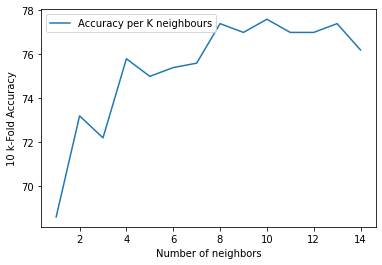

In [59]:
#Plot the result
plt.plot(range(1,15),accuracy_list_for_each_K_neighbours)
plt.legend(['Accuracy per K neighbours'], loc='upper left')
plt.xlabel("Number of neighbors")
plt.ylabel("10 k-Fold Accuracy")
plt.show()